# Analysis of different architectures of Adaptive Scaling on ResNet50 for CIFAR10

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.extend(['..'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import torch
import torch.nn as nn
from torch.nn.functional import softplus

%aimport models
from models import TempScaling, AdaTS, ScaleT, LinearT, HbasedT, DNNbasedT, HlogbasedT, HnLinearT
%aimport utils
from utils import compare_results, calib_split, torch_entropy
%aimport adats_utils
from adats_utils import fitAdaTS

In [4]:
%matplotlib inline

In [5]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

## Load data and precomputed logits

In [6]:
CIFAR10_PATH = '../../data/CIFAR10'
MODEL_PATH = '../../trained_models/CIFAR10/resnet50'

In [7]:
X_train = np.load(os.path.join(CIFAR10_PATH, 'train_imas.npy'))
y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))

X_val = np.load(os.path.join(CIFAR10_PATH, 'val_imas.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))

X_test = np.load(os.path.join(CIFAR10_PATH, 'test_imas.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [8]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

### Calibrate models

In [9]:
N, dim = Z_train.shape

### Temp-Scal as baseline:
tempScaler = TempScaling()
tempScaler.fit(Z_val, y_val, v=True);

In [10]:
laTempScaler = AdaTS(LinearT(dim))
laTempScaler = fitAdaTS(laTempScaler, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-2, v=True)

In [11]:
haTempScaler = AdaTS(HbasedT(dim))
haTempScaler = fitAdaTS(haTempScaler, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-2, v=True)

In [12]:
lhaTempScaler = AdaTS(HlogbasedT(dim))
lhaTempScaler = fitAdaTS(lhaTempScaler, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-3, v=True)

In [19]:
hnlaTempScaler = AdaTS(HnLinearT(dim))
hnlaTempScaler = fitAdaTS(hnlaTempScaler, Z_val, y_val, epochs=20000, batch_size=1000, lr=1e-3, v=True)

In [14]:
dnnaTempScaler = AdaTS(DNNbasedT(dim))
dnnaTempScaler = fitAdaTS(dnnaTempScaler, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-2, v=True, weight_decay=1e-2)

In [20]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScaler.predictive(Z_train),
                             'LinearAdaptiveTempScal': laTempScaler.predictive(Z_train),
                             'EntropyAdaptiveTempScal': haTempScaler.predictive(Z_train),
                             'log-EntropyAdaptiveTempScal': lhaTempScaler.predictive(Z_train),
                             'Linear + Entropy TS': hnlaTempScaler.predictive(Z_train),
                             'DNNAdaptiveTempScal': dnnaTempScaler.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                99.94%         0.11%        45.80%    1.104e-03     2.701e-03
TempScal                             99.94%         5.35%        65.23%    8.604e-03     5.811e-02
LinearAdaptiveTempScal               99.94%         5.33%        72.00%    9.513e-03     5.841e-02
EntropyAdaptiveTempScal              99.94%         4.71%        73.41%    1.007e-02     5.256e-02
log-EntropyAdaptiveTempScal          99.94%         4.79%        74.31%    9.569e-03     5.305e-02
Linear + Entropy TS                  99.94%         4.81%        74.63%    1.018e-02     5.363e-02
DNNAdaptiveTempScal                  99.94%         4.85%        42.42%    9.179e-03     5.349e-02


In [21]:
print('##### Results on validation set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScaler.predictive(Z_val),
                             'LinearAdaptiveTempScal': laTempScaler.predictive(Z_val),
                             'EntropyAdaptiveTempScal': haTempScaler.predictive(Z_val),
                             'log-EntropyAdaptiveTempScal': lhaTempScaler.predictive(Z_val),
                             'Linear + Entropy TS': hnlaTempScaler.predictive(Z_val),
                             'DNNAdaptiveTempScal': dnnaTempScaler.predictive(Z_val)}, target=y_val, M=15, from_logits=False);

##### Results on validation set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                86.72%        10.30%        73.80%    2.300e-01     7.737e-01
TempScal                             86.72%         2.49%        55.51%    1.967e-01     4.343e-01
LinearAdaptiveTempScal               86.72%         2.41%        25.89%    1.947e-01     4.278e-01
EntropyAdaptiveTempScal              86.72%         1.28%        80.40%    1.951e-01     4.299e-01
log-EntropyAdaptiveTempScal          86.72%         1.30%        80.79%    1.953e-01     4.305e-01
Linear + Entropy TS                  86.72%         1.43%        20.20%    1.937e-01     4.248e-01
DNNAdaptiveTempScal                  86.72%         2.51%        26.96%    1.953e-01     4.304e-01


In [22]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'LinearAdaptiveTempScal': laTempScaler.predictive(Z_test),
                             'EntropyAdaptiveTempScal': haTempScaler.predictive(Z_test),
                             'log-EntropyAdaptiveTempScal': lhaTempScaler.predictive(Z_test),
                             'Linear + Entropy TS': hnlaTempScaler.predictive(Z_test),
                             'DNNAdaptiveTempScal': dnnaTempScaler.predictive(Z_test)}, target=y_test, M=15, from_logits=False);

##### Results on test set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                86.13%        10.69%        35.80%    2.392e-01     7.897e-01
TempScal                             86.13%         2.35%        16.93%    2.037e-01     4.473e-01
LinearAdaptiveTempScal               86.13%         2.10%        18.35%    2.019e-01     4.399e-01
EntropyAdaptiveTempScal              86.13%         0.99%        14.50%    2.022e-01     4.443e-01
log-EntropyAdaptiveTempScal          86.13%         0.97%        15.98%    2.024e-01     4.448e-01
Linear + Entropy TS                  86.13%         1.25%        26.02%    2.011e-01     4.387e-01
DNNAdaptiveTempScal                  86.13%         2.13%        16.78%    2.024e-01     4.420e-01


### Temperature distribution

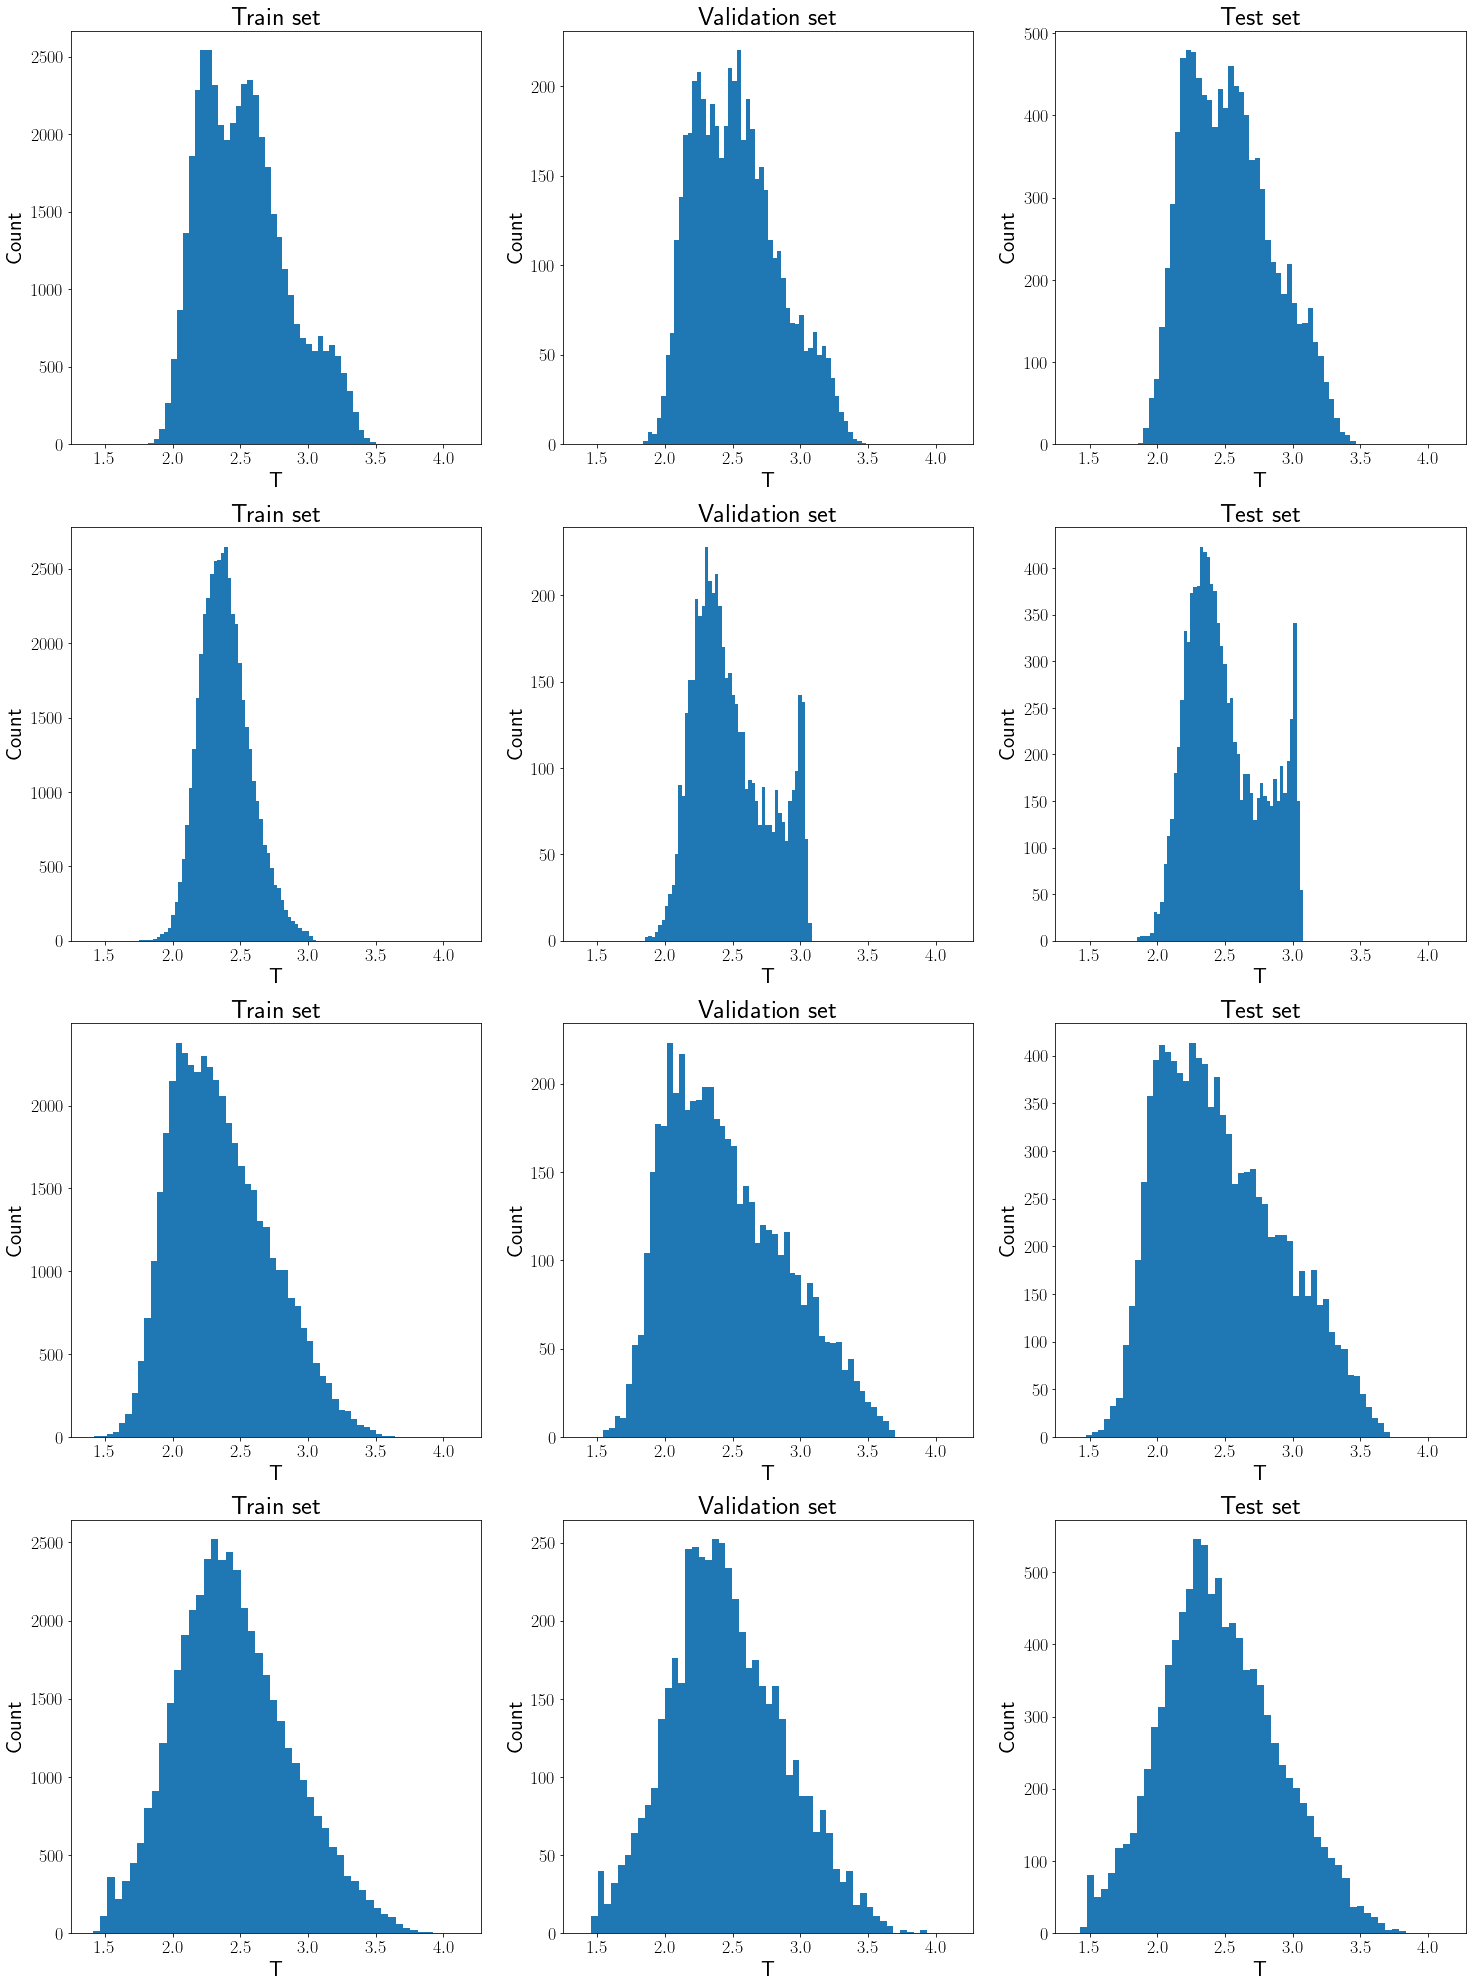

In [23]:
fig, ax = plt.subplots(4, 3, sharex=True, figsize=(25, 35))

Ts = laTempScaler.get_T(Z_train)
ax[0, 0].hist(Ts, bins=50)
ax[0, 0].set_xlabel('T', fontsize=22)
ax[0, 0].set_ylabel('Count', fontsize=22)
ax[0, 0].set_title('Train set', fontsize=26)

Ts = laTempScaler.get_T(Z_val)
ax[0, 1].hist(Ts, bins=50)
ax[0, 1].set_xlabel('T', fontsize=22)
ax[0, 1].set_ylabel('Count', fontsize=22)
ax[0, 1].set_title('Validation set', fontsize=26)

Ts = laTempScaler.get_T(Z_test)
ax[0, 2].hist(Ts, bins=50)
ax[0, 2].set_xlabel('T', fontsize=22)
ax[0, 2].set_ylabel('Count', fontsize=22)
ax[0, 2].set_title('Test set', fontsize=26)


## log-Entropy
Ts = lhaTempScaler.get_T(Z_train)
ax[1, 0].hist(Ts, bins=50)
ax[1, 0].set_xlabel('T', fontsize=22)
ax[1, 0].set_ylabel('Count', fontsize=22)
ax[1, 0].set_title('Train set', fontsize=26)

Ts = lhaTempScaler.get_T(Z_val)
ax[1, 1].hist(Ts, bins=50)
ax[1, 1].set_xlabel('T', fontsize=22)
ax[1, 1].set_ylabel('Count', fontsize=22)
ax[1, 1].set_title('Validation set', fontsize=26)

Ts = lhaTempScaler.get_T(Z_test)
ax[1, 2].hist(Ts, bins=50)
ax[1, 2].set_xlabel('T', fontsize=22)
ax[1, 2].set_ylabel('Count', fontsize=22)
ax[1, 2].set_title('Test set', fontsize=26)


## lin + Entropy
Ts = hnlaTempScaler.get_T(Z_train)
ax[2, 0].hist(Ts, bins=50)
ax[2, 0].set_xlabel('T', fontsize=22)
ax[2, 0].set_ylabel('Count', fontsize=22)
ax[2, 0].set_title('Train set', fontsize=26)

Ts = hnlaTempScaler.get_T(Z_val)
ax[2, 1].hist(Ts, bins=50)
ax[2, 1].set_xlabel('T', fontsize=22)
ax[2, 1].set_ylabel('Count', fontsize=22)
ax[2, 1].set_title('Validation set', fontsize=26)

Ts = hnlaTempScaler.get_T(Z_test)
ax[2, 2].hist(Ts, bins=50)
ax[2, 2].set_xlabel('T', fontsize=22)
ax[2, 2].set_ylabel('Count', fontsize=22)
ax[2, 2].set_title('Test set', fontsize=26)


## DNN
Ts = dnnaTempScaler.get_T(Z_train)
ax[3, 0].hist(Ts, bins=50)
ax[3, 0].set_xlabel('T', fontsize=22)
ax[3, 0].set_ylabel('Count', fontsize=22)
ax[3, 0].set_title('Train set', fontsize=26)

Ts = dnnaTempScaler.get_T(Z_val)
ax[3, 1].hist(Ts, bins=50)
ax[3, 1].set_xlabel('T', fontsize=22)
ax[3, 1].set_ylabel('Count', fontsize=22)
ax[3, 1].set_title('Validation set', fontsize=26)

Ts = dnnaTempScaler.get_T(Z_test)
ax[3, 2].hist(Ts, bins=50)
ax[3, 2].set_xlabel('T', fontsize=22)
ax[3, 2].set_ylabel('Count', fontsize=22)
ax[3, 2].set_title('Test set', fontsize=26)

for _ax in ax.flatten():
    _ax.tick_params(axis='both', labelsize=18)
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    

plt.show()

### Selected temperature for different confidences in test set

In [21]:
hc, lc, hi, li = calib_split(Z_test, y_test)

ts_aux = TempScaling()
ts_aux.fit(Z_test[hc | hi], y_test[hc | hi]);
T_hc = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[lc | li], y_test[lc | li]);
T_lc = ts_aux.T.detach().numpy()


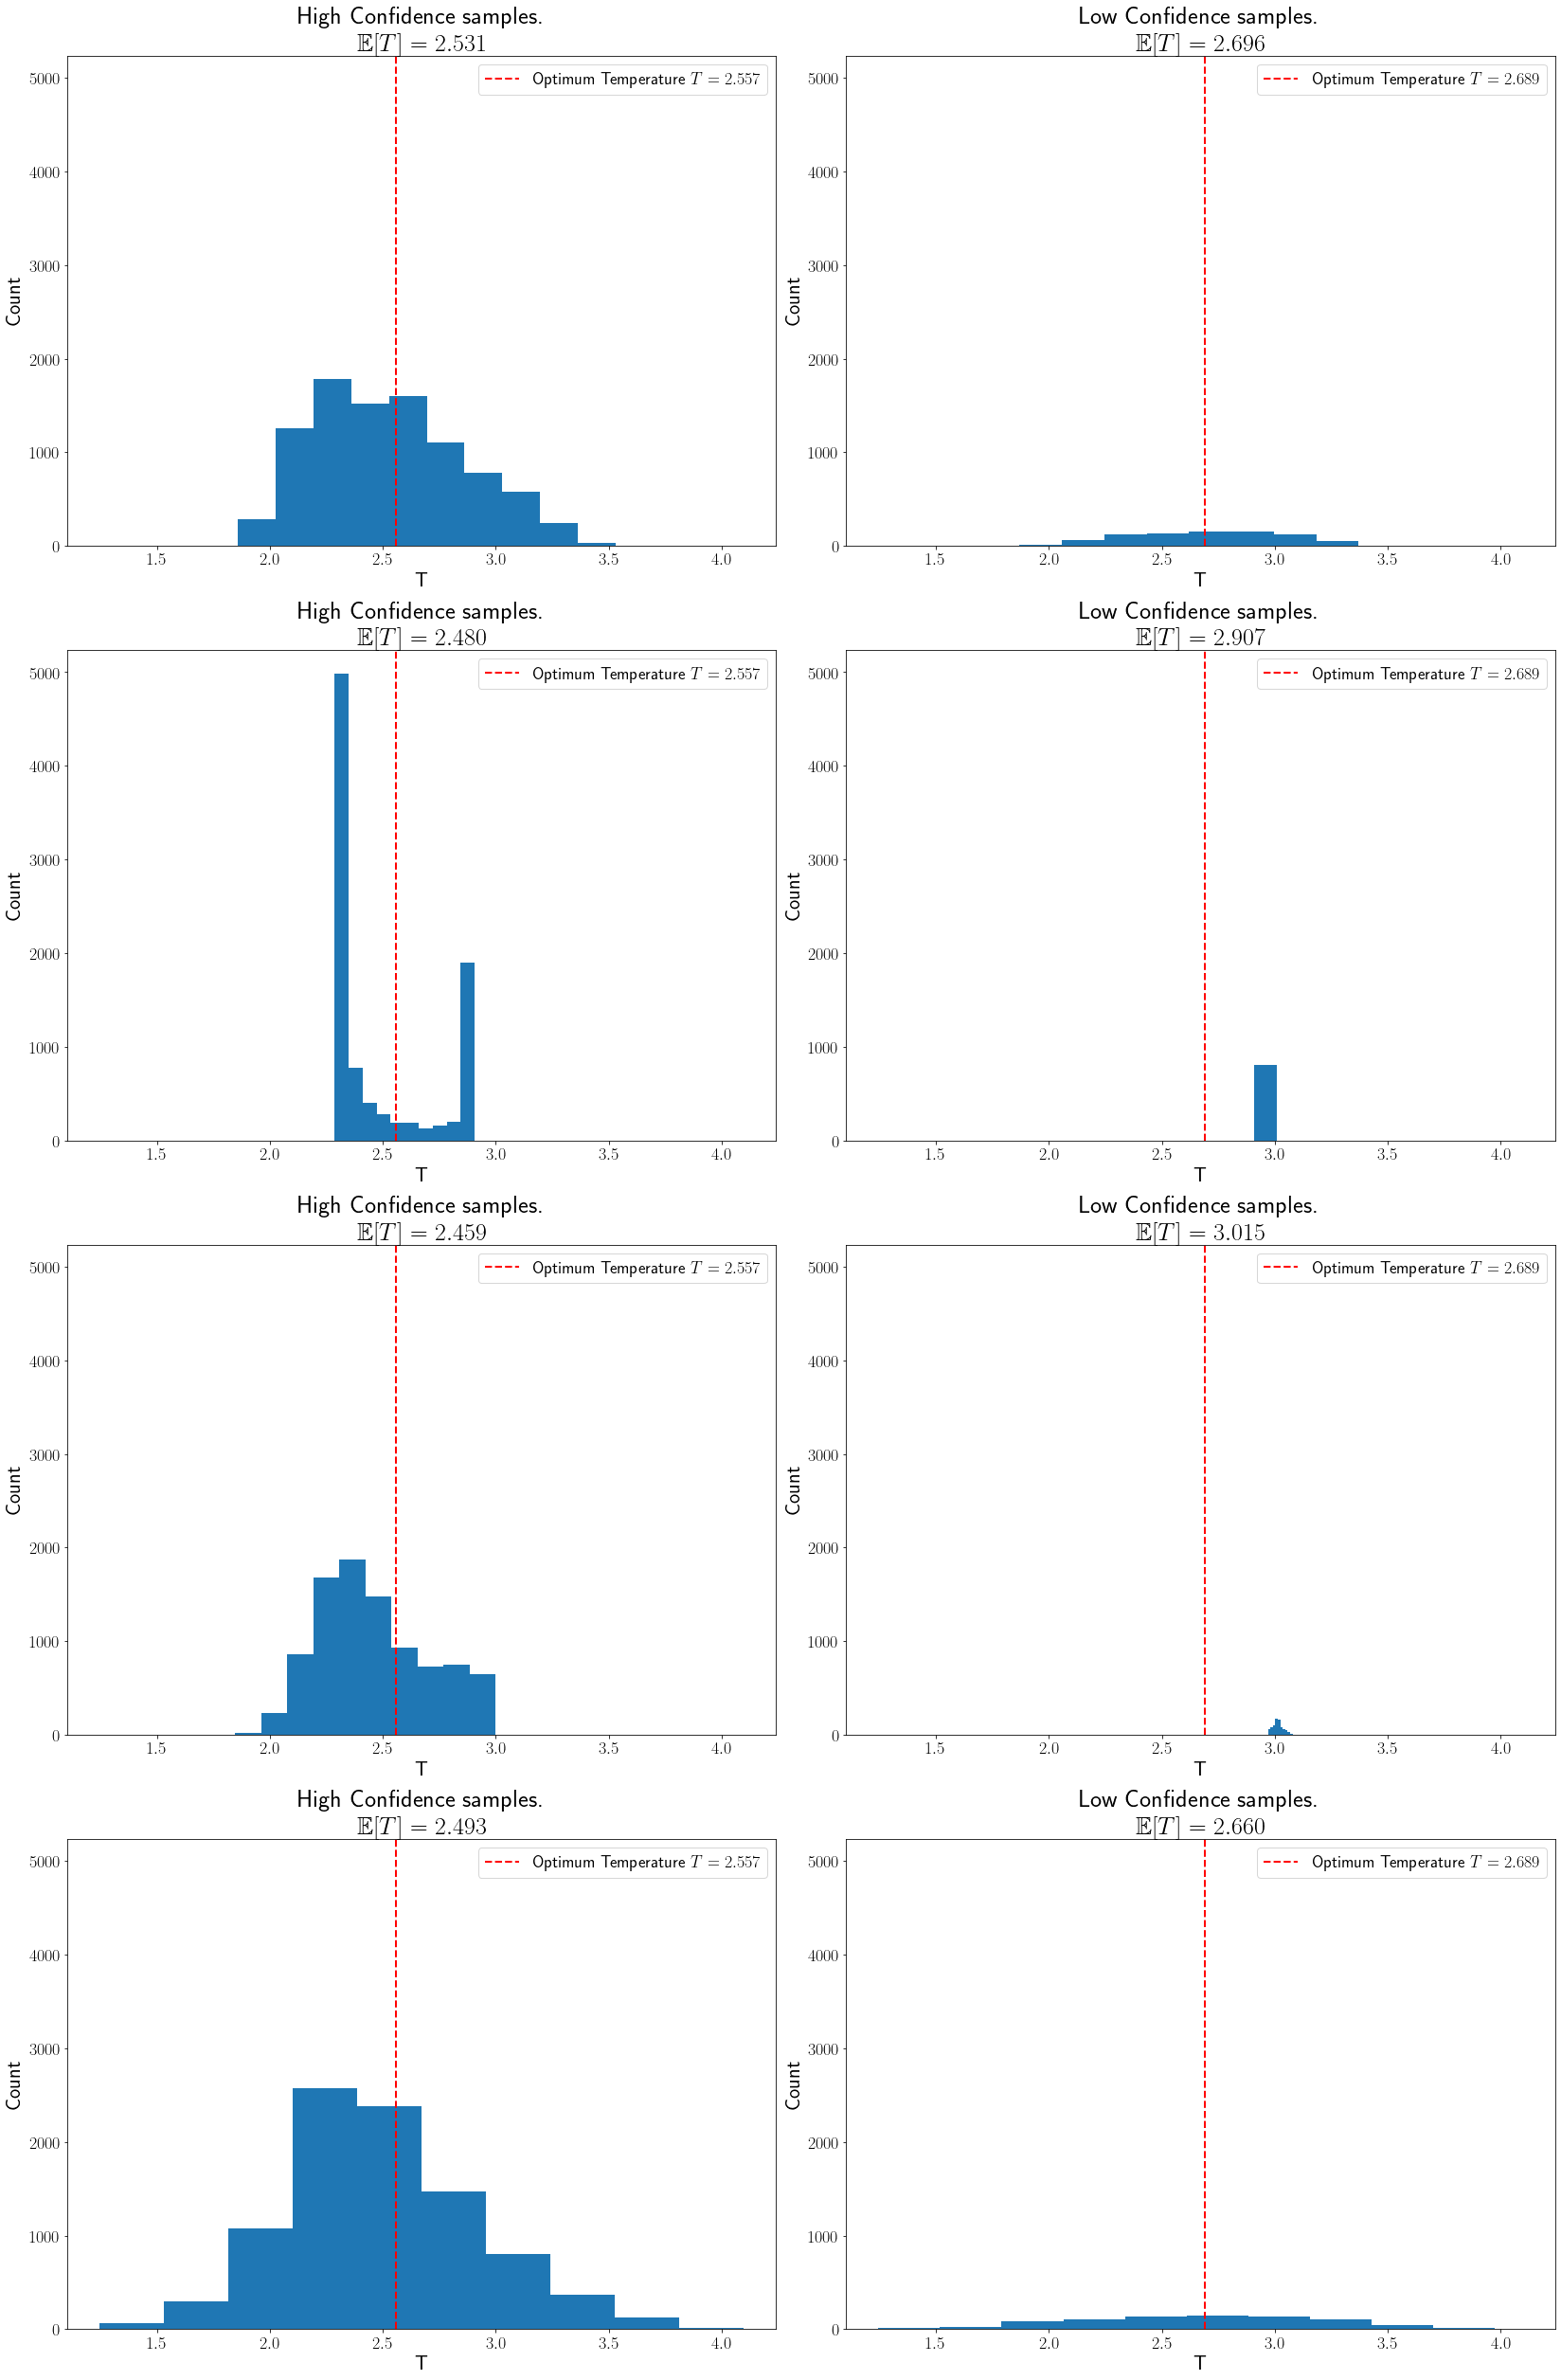

In [22]:
Ts = laTempScaler.get_T(Z_test)
hTs = haTempScaler.get_T(Z_test)
lhTs = lhaTempScaler.get_T(Z_test)
nnTs = dnnaTempScaler.get_T(Z_test)

fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(23, 35))

# Adaptive
ax[0, 0].hist(Ts[hc | hi])
ax[0, 0].axvline(T_hc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_hc[0]))
ax[0, 0].set_title('High Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc | hi])), fontsize=26)
ax[0, 0].legend(fontsize=18)

ax[0, 1].hist(Ts[lc | li])
ax[0, 1].axvline(T_lc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_lc[0]))
ax[0, 1].set_title('Low Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[lc | li])), fontsize=26)
ax[0, 1].legend(fontsize=18)


# Entropy-adapted
ax[1, 0].hist(hTs[hc | hi])
ax[1, 0].axvline(T_hc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_hc[0]))
ax[1, 0].set_title('High Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(hTs[hc | hi])), fontsize=26)
ax[1, 0].legend(fontsize=18)

ax[1, 1].hist(hTs[lc | li])
ax[1, 1].axvline(T_lc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_lc[0]))
ax[1, 1].set_title('Low Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(hTs[lc | li])), fontsize=26)
ax[1, 1].legend(fontsize=18)


# log-Entropy adaptive
ax[2, 0].hist(lhTs[hc | hi])
ax[2, 0].axvline(T_hc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_hc[0]))
ax[2, 0].set_title('High Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(lhTs[hc | hi])), fontsize=26)
ax[2, 0].legend(fontsize=18)

ax[2, 1].hist(lhTs[lc | li])
ax[2, 1].axvline(T_lc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_lc[0]))
ax[2, 1].set_title('Low Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(lhTs[lc | li])), fontsize=26)
ax[2, 1].legend(fontsize=18)


# DNN adaptive
ax[3, 0].hist(nnTs[hc | hi])
ax[3, 0].axvline(T_hc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_hc[0]))
ax[3, 0].set_title('High Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(nnTs[hc | hi])), fontsize=26)
ax[3, 0].legend(fontsize=18)

ax[3, 1].hist(nnTs[lc | li])
ax[3, 1].axvline(T_lc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_lc[0]))
ax[3, 1].set_title('Low Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(nnTs[lc | li])), fontsize=26)
ax[3, 1].legend(fontsize=18)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)
    
plt.tight_layout()
plt.show();

### According to quantiles

In [24]:
test_probs = softmax(Z_test, axis=1)
test_confs = np.max(test_probs, axis=1)

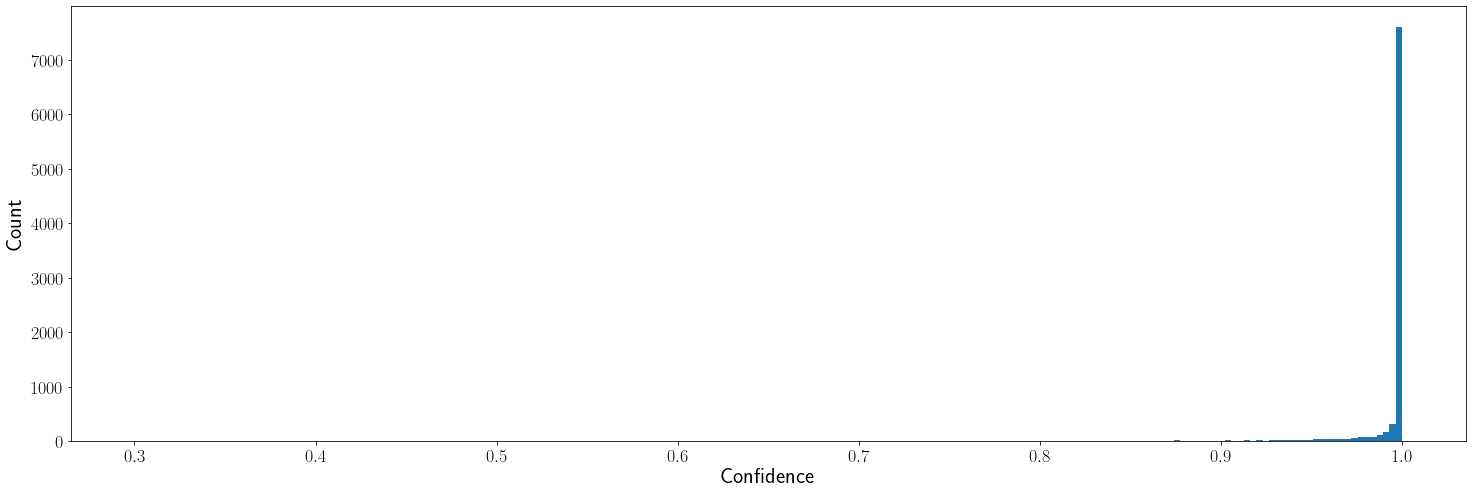

In [25]:
fig, ax = plt.subplots(figsize=(25, 8))

ax.hist(test_confs, bins=200)

ax.set_xlabel('Confidence', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
ax.tick_params(axis='both', labelsize=18)

plt.show();

In [26]:
ix = np.argsort(test_confs)

q1, q2, q3, q4 = ix[:len(test_confs)//4], ix[len(test_confs)//4:len(test_confs)//2], ix[len(test_confs)//2: 3*len(test_confs)//4], ix[3*len(test_confs)//4:]


ts_aux = TempScaling()
ts_aux.fit(Z_test[q1], y_test[q1]);
T_q1 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q2], y_test[q2]);
T_q2 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q3], y_test[q3]);
T_q3 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q4], y_test[q4]);
T_q4 = ts_aux.T.detach().numpy()



Ts = laTempScaler.get_T(Z_test)
TsH = haTempScaler.get_T(Z_test)
TslH = lhaTempScaler.get_T(Z_test)
TsHnl = hnlaTempScaler.get_T(Z_test)
TsDNN = dnnaTempScaler.get_T(Z_test)

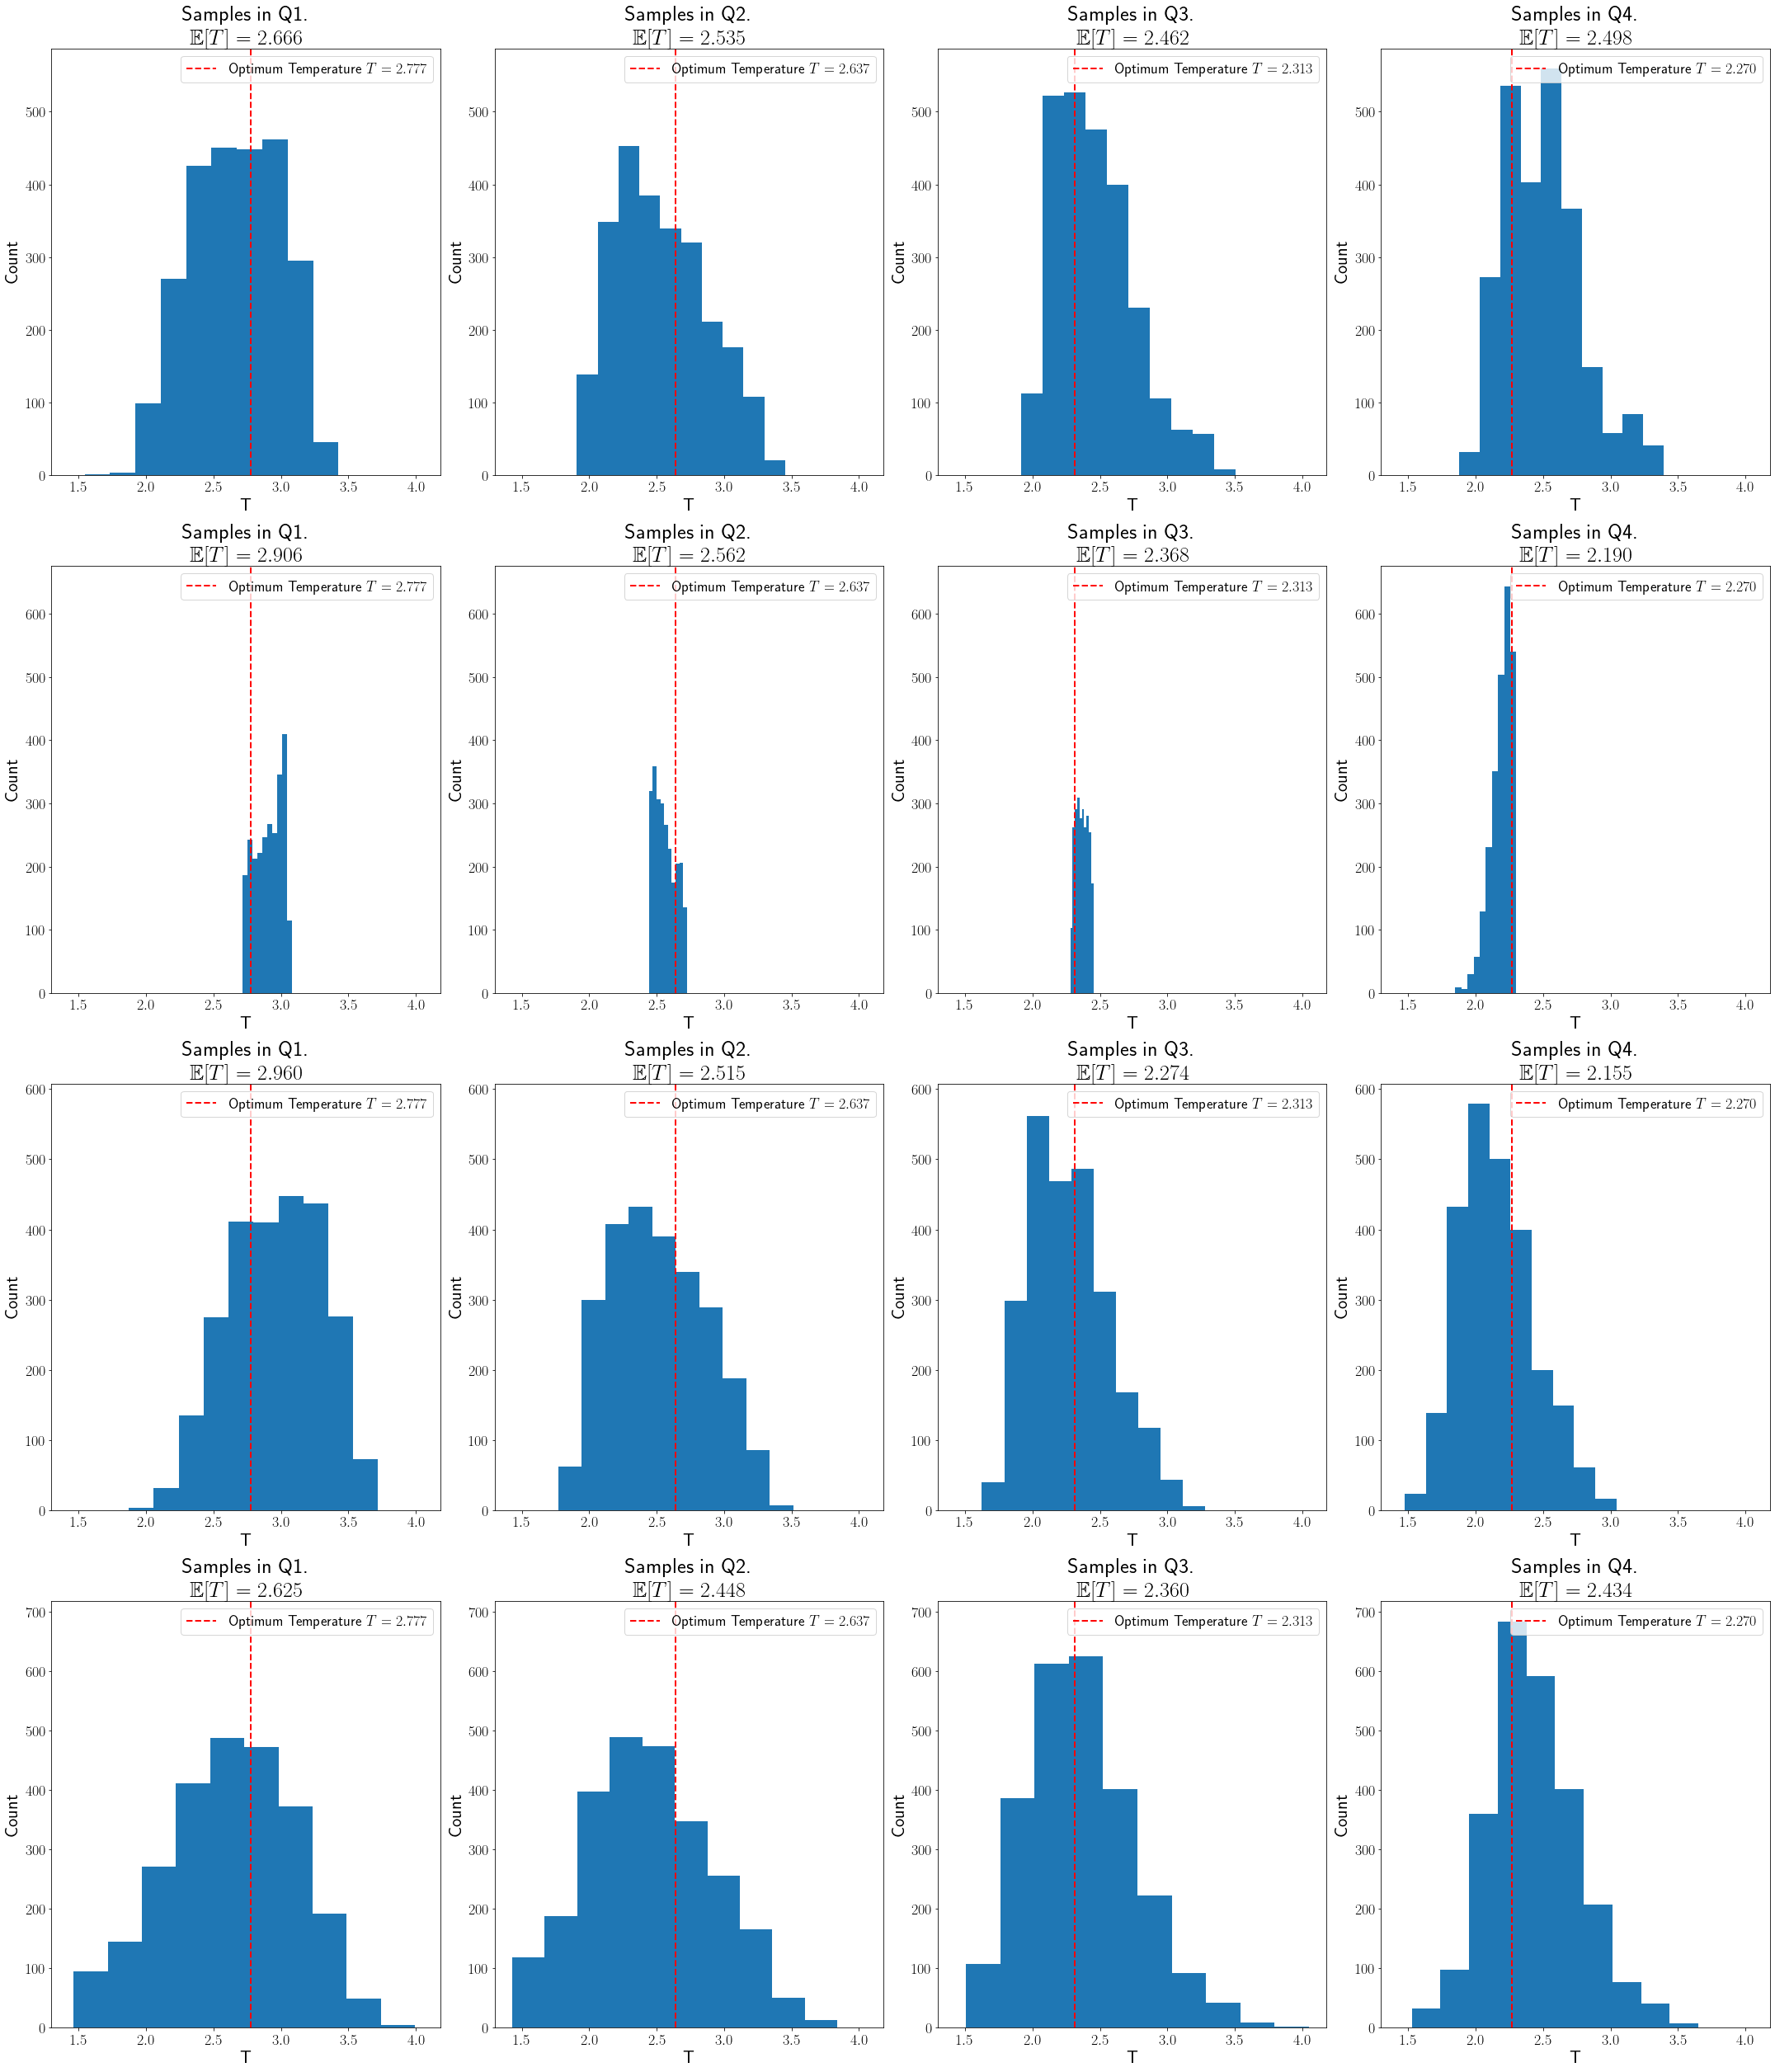

In [27]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey='row', figsize=(30, 35))


ax[0, 0].hist(Ts[q1])
ax[0, 0].axvline(T_q1, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q1[0]))
ax[0, 0].set_title('Samples in Q1.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q1])), fontsize=26)

ax[0, 1].hist(Ts[q2])
ax[0, 1].axvline(T_q2, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q2[0]))
ax[0, 1].set_title('Samples in Q2.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q2])), fontsize=26)

ax[0, 2].hist(Ts[q3])
ax[0, 2].axvline(T_q3, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q3[0]))
ax[0, 2].set_title('Samples in Q3.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q3])), fontsize=26)

ax[0, 3].hist(Ts[q4])
ax[0, 3].axvline(T_q4, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q4[0]))
ax[0, 3].set_title('Samples in Q4.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q4])), fontsize=26)



ax[1, 0].hist(TslH[q1])
ax[1, 0].axvline(T_q1, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q1[0]))
ax[1, 0].set_title('Samples in Q1.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TslH[q1])), fontsize=26)

ax[1, 1].hist(TslH[q2])
ax[1, 1].axvline(T_q2, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q2[0]))
ax[1, 1].set_title('Samples in Q2.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TslH[q2])), fontsize=26)

ax[1, 2].hist(TslH[q3])
ax[1, 2].axvline(T_q3, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q3[0]))
ax[1, 2].set_title('Samples in Q3.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TslH[q3])), fontsize=26)

ax[1, 3].hist(TslH[q4])
ax[1, 3].axvline(T_q4, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q4[0]))
ax[1, 3].set_title('Samples in Q4.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TslH[q4])), fontsize=26)



ax[2, 0].hist(TsHnl[q1])
ax[2, 0].axvline(T_q1, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q1[0]))
ax[2, 0].set_title('Samples in Q1.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsHnl[q1])), fontsize=26)

ax[2, 1].hist(TsHnl[q2])
ax[2, 1].axvline(T_q2, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q2[0]))
ax[2, 1].set_title('Samples in Q2.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsHnl[q2])), fontsize=26)

ax[2, 2].hist(TsHnl[q3])
ax[2, 2].axvline(T_q3, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q3[0]))
ax[2, 2].set_title('Samples in Q3.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsHnl[q3])), fontsize=26)

ax[2, 3].hist(TsHnl[q4])
ax[2, 3].axvline(T_q4, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q4[0]))
ax[2, 3].set_title('Samples in Q4.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsHnl[q4])), fontsize=26)



ax[3, 0].hist(TsDNN[q1])
ax[3, 0].axvline(T_q1, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q1[0]))
ax[3, 0].set_title('Samples in Q1.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsDNN[q1])), fontsize=26)

ax[3, 1].hist(TsDNN[q2])
ax[3, 1].axvline(T_q2, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q2[0]))
ax[3, 1].set_title('Samples in Q2.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsDNN[q2])), fontsize=26)

ax[3, 2].hist(TsDNN[q3])
ax[3, 2].axvline(T_q3, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q3[0]))
ax[3, 2].set_title('Samples in Q3.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsDNN[q3])), fontsize=26)

ax[3, 3].hist(TsDNN[q4])
ax[3, 3].axvline(T_q4, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q4[0]))
ax[3, 3].set_title('Samples in Q4.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(TsDNN[q4])), fontsize=26)



for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    _ax.legend(fontsize=18)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)
    
plt.tight_layout()

plt.show();